In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from numpy import load
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time

2023-10-29 19:16:05.574623: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 19:16:05.574656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 19:16:05.575165: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 19:16:05.664610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 19:16:06.846722: W tensorflow/compiler/

In [2]:
import os

# Define the root directory of your dataset
root_path = '/home/mrroy/Dataset'

# Function to print directory names without listing files
def print_directory_structure(path, indent=0):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print('  ' * indent + f'[{item}]')
            print_directory_structure(item_path, indent + 1)

# Print the directory structure without individual files
print_directory_structure(root_path)


[vgg19_models]
[.ipynb_checkpoints]
[CLASS]
  [test]
    [4]
    [1]
    [2]
    [3]
    [0]
  [4]
  [1]
  [train]
    [4]
    [1]
    [2]
    [3]
    [0]
  [2]
  [validation]
    [4]
    [1]
    [2]
    [3]
    [0]
  [3]
  [0]
[densenet_models]
[eye]
[cnn_models]
[models]


In [3]:
import os
from PIL import Image
import numpy as np

# Define your dataset directory paths
root_path = '/home/mrroy/Dataset'
dataset_folder = 'CLASS'  # Assuming the "CLASS" directory contains "train," "test," and "validation"
train_folder = 'train'  # Change to 'test' or 'validation' as needed
image_size = 28
IMAGE_CHANNELS = 1

PREVIEW_ROWS = 58
PREVIEW_COLS = 58
PREVIEW_MARGIN = 1

SEED_SIZE = 100

EPOCHS = 1000
BATCH_SIZE = 32
BUFFER_SIZE = 60000

# Update the paths accordingly
training_binary_path = os.path.join(root_path, f'{train_folder}_training_data_{image_size}_{image_size}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
    print(f"Loading training images from the '{train_folder}' directory...")
    training_data = []

    class_path = os.path.join(root_path, dataset_folder, train_folder)
    for root, dirs, files in os.walk(class_path):
        for filename in files:
            if filename.endswith(('.jpg', '.png', '.jpeg', '.bmp')):  # Add more image extensions as needed
                path = os.path.join(root, filename)
                image = Image.open(path).resize((image_size, image_size), Image.ANTIALIAS)
                training_data.append(np.asarray(image))

    training_data = np.reshape(training_data, (-1, image_size, image_size, IMAGE_CHANNELS))
    training_data = training_data.astype(np.float32)
    training_data = (training_data - 127.5) / 127.5

    print("Saving training image binary...")
    np.save(training_binary_path, training_data)
else:
    print("Loading previous training pickle...")
    training_data = np.load(training_binary_path)


Looking for file: /home/mrroy/Dataset/train_training_data_28_28.npy
Loading training images from the 'train' directory...
Saving training image binary...


In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-10-29 19:22:42.367061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 19:22:42.471793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 19:22:42.472066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
training_data.shape

(73719, 28, 28, 1)

Loaded:  (73719, 28, 28, 1)


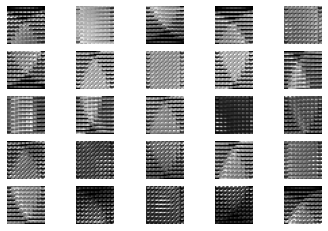

In [8]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot

def plot_dataset(training_data, n):

	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(training_data[i, :, :, 0],  cmap='gray')
	pyplot.show()

data = training_data
dataset = data
print('Loaded: ', dataset.shape)
plot_dataset(dataset, 5)

In [9]:
# generator model of DCGAN
def make_generator_model(seed_size, channels):
    
    model = Sequential()

    model.add(Dense(1024,activation="relu",input_dim=seed_size))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Dense(7*7*128,activation="relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Reshape((7,7,128)))
    model.add(UpSampling2D())

    model.add(Conv2D(64,kernel_size=3,padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(channels,kernel_size=3,padding='same'))
    model.add(Activation("tanh"))

    # model.summary()
    plot_model(model, show_shapes=True, to_file = 'generator_model.png')
    return model



In [10]:
# Discriminator model of DCGAN
def make_discriminator_model(image_shape):

    model = Sequential()

    model.add(Conv2D(64, kernel_size=5, strides=2, input_shape=image_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())

    model.add(Dense(256,activation="relu"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))

    model.add(Dense(1, activation='sigmoid'))
    # model.summary()
    plot_model(model, show_shapes=True, to_file = 'discriminator_model.png')
    return model

In [11]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (image_size+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (image_size+PREVIEW_MARGIN)), 3), 0 , dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (image_size+1) + PREVIEW_MARGIN
        c = col * (image_size+1) + PREVIEW_MARGIN
        image_array[r:r+image_size,c:c+image_size] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join('/home/mrroy/Dataset','Gan_Result') #location to save images
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"111_train-{cnt}.jpg")  #save dcgan generated images on folder 
  im = Image.fromarray(image_array)
  im.save(filename)

2023-10-29 19:36:33.891707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


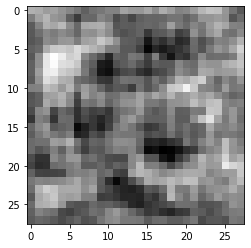

In [12]:
generator = make_generator_model(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([100, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:

image_shape = (28,28,1)

discriminator = make_discriminator_model(image_shape)
decision = discriminator(generated_image)
print(decision)


tf.Tensor(
[[0.5007272 ]
 [0.50094616]
 [0.49675316]
 [0.5026147 ]
 [0.50041777]
 [0.50043315]
 [0.49886116]
 [0.4997604 ]
 [0.5006985 ]
 [0.49965703]
 [0.50134605]
 [0.49684843]
 [0.4982419 ]
 [0.50058573]
 [0.50141686]
 [0.5001387 ]
 [0.5005523 ]
 [0.50405693]
 [0.5002905 ]
 [0.49930584]
 [0.4999098 ]
 [0.49969035]
 [0.49988547]
 [0.50200015]
 [0.49915886]
 [0.5022908 ]
 [0.50237495]
 [0.49949005]
 [0.49968442]
 [0.50056356]
 [0.49952564]
 [0.49835676]
 [0.50008523]
 [0.50099766]
 [0.4998477 ]
 [0.49916953]
 [0.50138867]
 [0.5009806 ]
 [0.5013118 ]
 [0.50113183]
 [0.5002699 ]
 [0.5017996 ]
 [0.49870712]
 [0.50004536]
 [0.49979982]
 [0.49955335]
 [0.49786788]
 [0.49908638]
 [0.5002953 ]
 [0.5018441 ]
 [0.49895424]
 [0.50115716]
 [0.4995442 ]
 [0.5005925 ]
 [0.5022367 ]
 [0.500051  ]
 [0.5021447 ]
 [0.5010289 ]
 [0.49923187]
 [0.5005144 ]
 [0.50003195]
 [0.5013726 ]
 [0.500402  ]
 [0.49889886]
 [0.49969882]
 [0.500512  ]
 [0.49940038]
 [0.49990335]
 [0.49946687]
 [0.5003108 ]
 [0.49801

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)
    print (generated_images)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [17]:
def train(dataset, epochs):
  
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()
  for epoch in range(epochs):

   
    gen_loss_list = []
    disc_loss_list = []
   
    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
   

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)
    

    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')
    if (epoch+1)%100==0:
      save_images(epoch,fixed_seed)
      print (f'Save image in Epoch {epoch+1}','Time {0:.5} sec'.format(time.time()-start))

In [18]:
train(train_dataset, EPOCHS)

2023-10-29 19:37:16.922363: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 231182784 exceeds 10% of free system memory.


Tensor("sequential/activation_3/Tanh:0", shape=(32, 28, 28, 1), dtype=float32)
Tensor("sequential/activation_3/Tanh:0", shape=(32, 28, 28, 1), dtype=float32)


2023-10-29 19:37:20.933025: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9bf727c650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-29 19:37:20.933050: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2023-10-29 19:37:20.942307: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-29 19:37:21.072675: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Tensor("sequential/activation_3/Tanh:0", shape=(32, 28, 28, 1), dtype=float32)
Epoch 1, gen loss=1.4913958311080933,disc loss=0.8520309329032898
Epoch 2, gen loss=1.1315478086471558,disc loss=1.0919827222824097
Epoch 3, gen loss=1.1166785955429077,disc loss=1.0930958986282349
Epoch 4, gen loss=1.1521838903427124,disc loss=1.0719571113586426
Epoch 5, gen loss=1.195160150527954,disc loss=1.0439019203186035
Epoch 6, gen loss=1.2329661846160889,disc loss=1.019385814666748
Epoch 7, gen loss=1.2737773656845093,disc loss=0.9939911961555481
Epoch 8, gen loss=1.3230187892913818,disc loss=0.9678118824958801
Epoch 9, gen loss=1.3684908151626587,disc loss=0.9431511759757996
Epoch 10, gen loss=1.3998887538909912,disc loss=0.9266966581344604
Epoch 11, gen loss=1.4360144138336182,disc loss=0.9063150882720947
Epoch 12, gen loss=1.474534511566162,disc loss=0.8881266117095947
Epoch 13, gen loss=1.5053057670593262,disc loss=0.8727845549583435
Epoch 14, gen loss=1.5408598184585571,disc loss=0.855515718460